Task 1: Basic Time Series Properties Analysis

What we're looking for in Task 1:

Trend: Is the price generally going up, down, or staying flat over time?

Stationarity: Do the statistical properties (mean, variance) stay constant over time?

Basic understanding of the data structure

Step 1: Load and Examine the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("../data/BrentOilprices.csv") 

# First look at the data
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nBasic info:")
print(df.info())

Dataset shape: (9011, 2)

First few rows:
        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63

Data types:
Date      object
Price    float64
dtype: object

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
None


Step 2: Convert Date Column and Set Index

Why this matters: Time series analysis needs dates in the right format. Setting date as index makes plotting and analysis easier.

In [3]:
# Safely parse mixed date formats
df['Date'] = pd.to_datetime(df['Date'], format='mixed', errors='coerce')

# Check if any failed to parse
if df['Date'].isna().sum() > 0:
    print(f"⚠️ Unparsed rows: {df['Date'].isna().sum()}")

# Sort by date (just in case)
df = df.sort_values('Date')

# Set date as index for easier time series analysis
df.set_index('Date', inplace=True)

print("Date range:", df.index.min(), "to", df.index.max())
print("Number of days:", len(df))

Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Number of days: 9011


Step 3: Check for Missing Values and Data Quality

In [4]:
# Check for missing values
print("Missing values:", df.isnull().sum())

# Check for duplicate dates
print("Duplicate dates:", df.index.duplicated().sum())

# Basic statistics
print("\nPrice statistics:")
print(df['Price'].describe())

Missing values: Price    0
dtype: int64
Duplicate dates: 0

Price statistics:
count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64


Step 4: Visual Inspection - The Whole Time Series

This shows the big picture - major price spikes, crashes, and overall trends

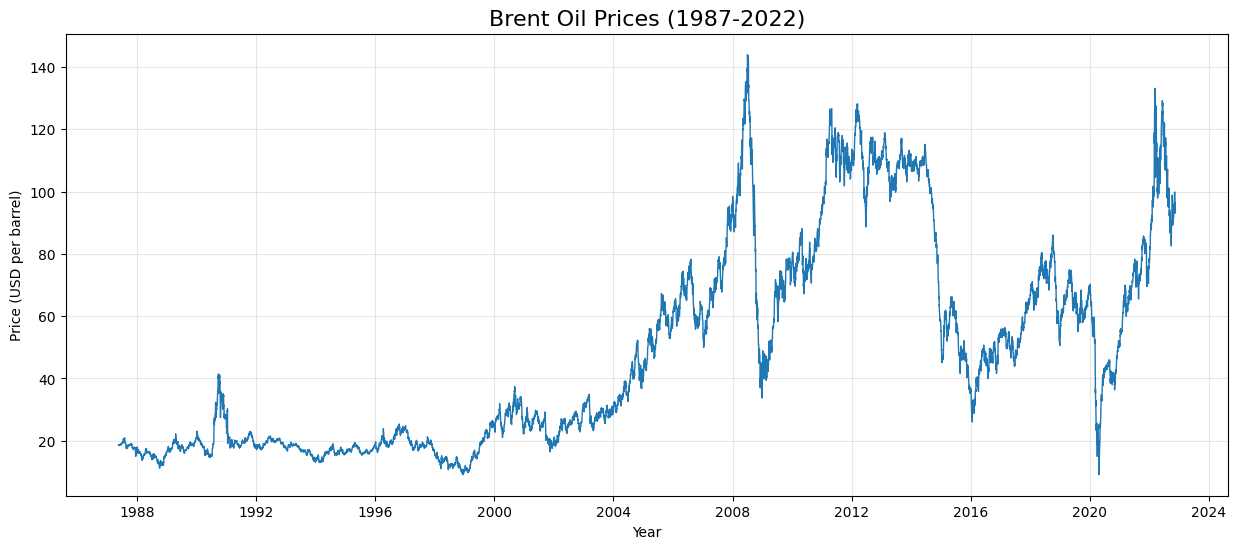

In [5]:
# Plot the entire time series
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Price'], linewidth=1)
plt.title('Brent Oil Prices (1987-2022)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Price (USD per barrel)')
plt.grid(True, alpha=0.3)
plt.show()

Step 5: Trend Analysis

Why rolling averages: They smooth out daily noise and show the underlying trend. If the 1-year average is going up over time, there's an upward trend.

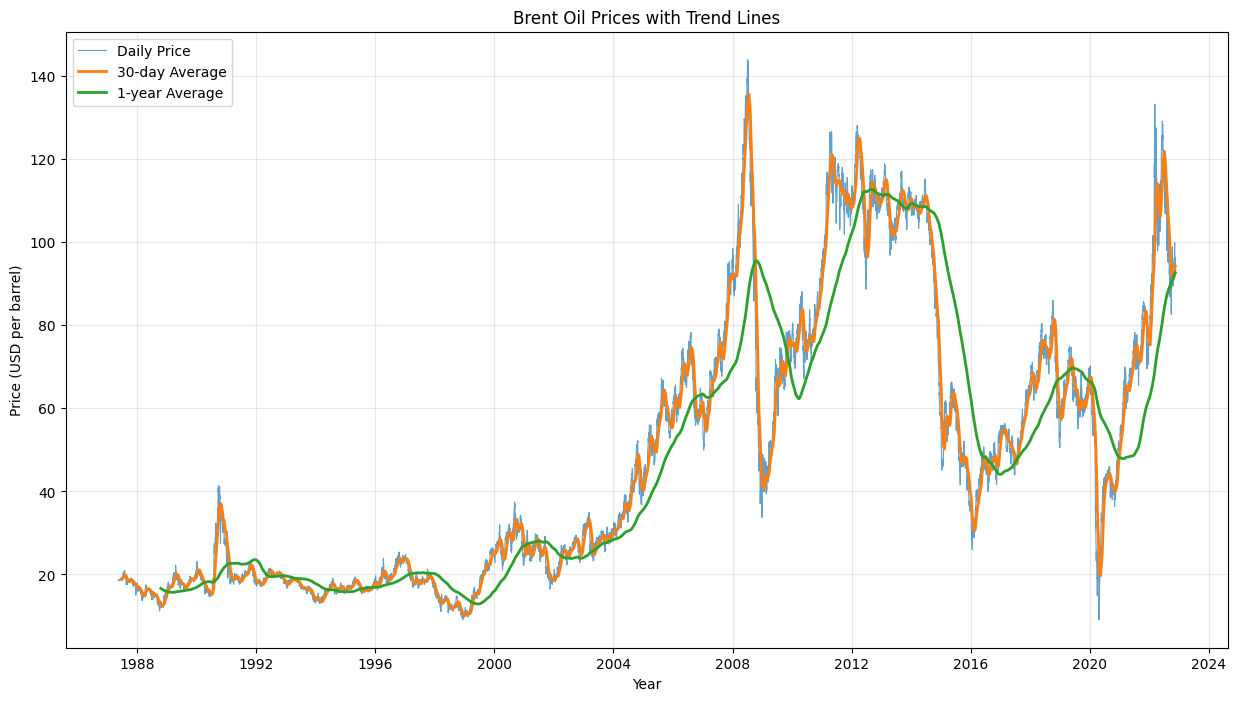

In [6]:
# Calculate rolling averages to see trends
df['30day_avg'] = df['Price'].rolling(window=30).mean()
df['365day_avg'] = df['Price'].rolling(window=365).mean()

# Plot with trend lines
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Price'], alpha=0.7, label='Daily Price', linewidth=0.8)
plt.plot(df.index, df['30day_avg'], label='30-day Average', linewidth=2)
plt.plot(df.index, df['365day_avg'], label='1-year Average', linewidth=2)
plt.title('Brent Oil Prices with Trend Lines')
plt.xlabel('Year')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Step 6: Stationarity Check - Visual Method

 If the data is stationary, each period should have similar mean and variance. If they're very different, the data is non-stationary.

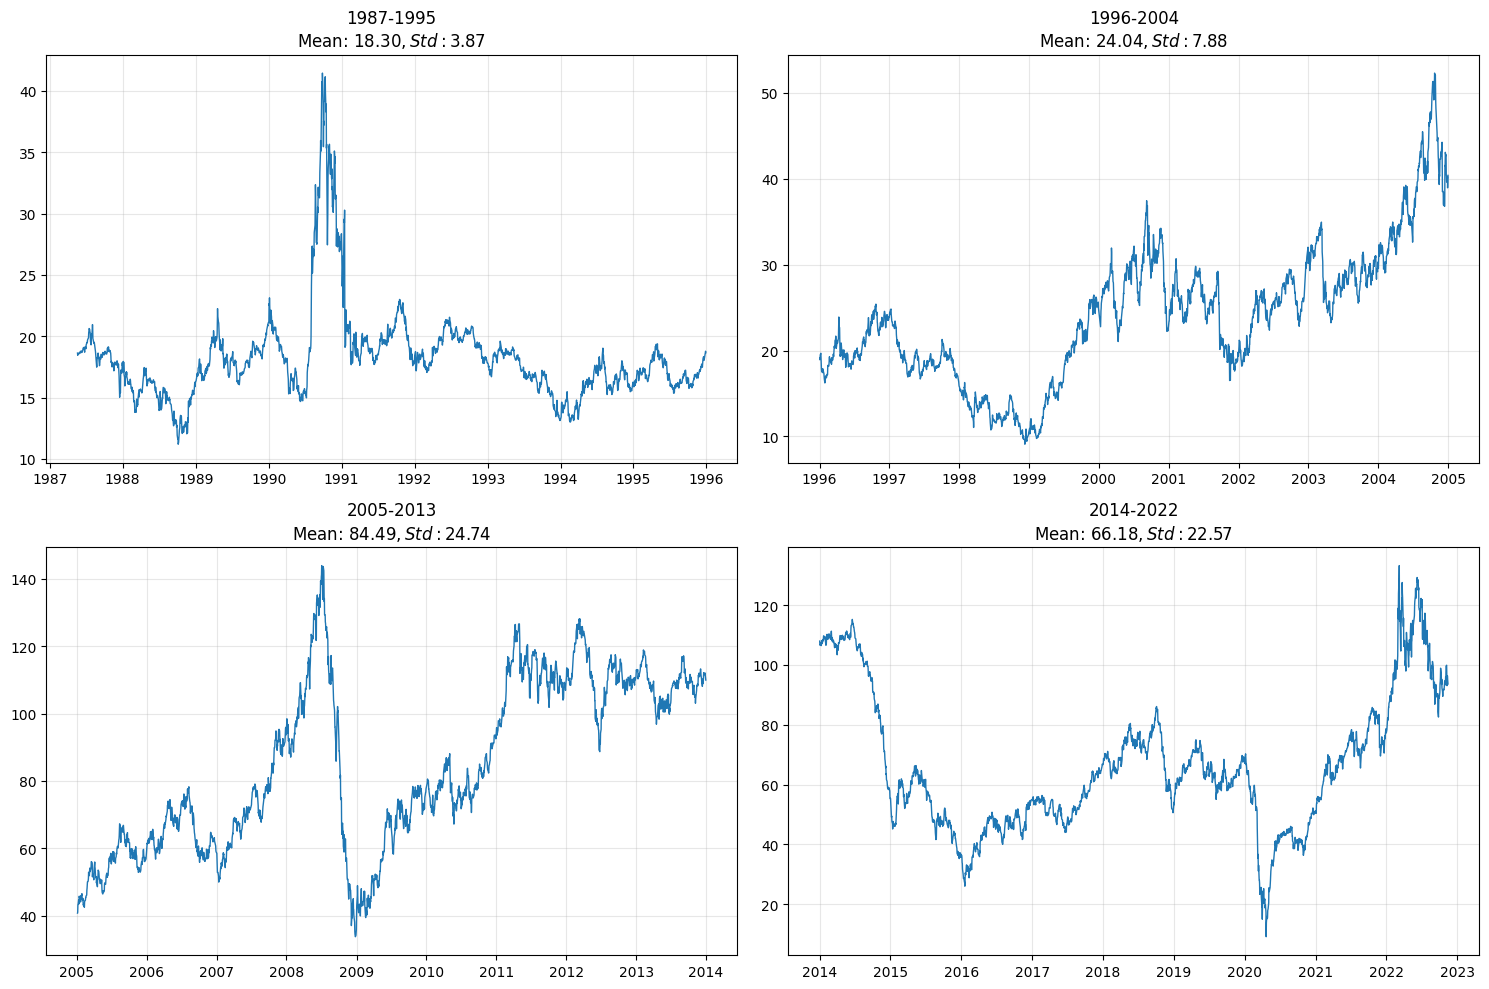

In [17]:
# Create subplots for different time periods
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Divide data into 4 periods
periods = [
    ('1987-1995', '1987', '1995'),
    ('1996-2004', '1996', '2004'), 
    ('2005-2013', '2005', '2013'),
    ('2014-2022', '2014', '2022')
]

for i, (label, start, end) in enumerate(periods):
    row = i // 2
    col = i % 2
    
    period_data = df[start:end]['Price']
    axes[row, col].plot(period_data.index, period_data, linewidth=1)
    axes[row, col].set_title(f'{label}\nMean: ${period_data.mean():.2f}, Std: ${period_data.std():.2f}')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Step 7: Simple Stationarity Test

 If means and standard deviations are very different across periods, the series is non-stationary.

In [4]:
from scipy import stats

# Calculate basic stats for each decade
decades = ['1987-1995', '1996-2004', '2005-2013', '2014-2022']
stats_by_decade = []

for i, (start, end) in enumerate([('1987', '1995'), ('1996', '2004'), 
                                 ('2005', '2013'), ('2014', '2022')]):
    period_data = df[start:end]['Price']
    stats_by_decade.append({
        'Period': decades[i],
        'Mean': period_data.mean(),
        'Std': period_data.std(),
        'Min': period_data.min(),
        'Max': period_data.max()
    })

stats_df = pd.DataFrame(stats_by_decade)
print("Statistics by decade:")
print(stats_df.round(2))

Statistics by decade:
      Period   Mean    Std    Min     Max
0  1987-1995  18.30   3.87  11.20   41.45
1  1996-2004  24.04   7.88   9.10   52.28
2  2005-2013  84.49  24.74  33.73  143.95
3  2014-2022  66.18  22.57   9.12  133.18



Step 8: Identify Major Price Shocks Visually

These extreme movements often correspond to major events. We'll use this to validate our change point detection later.

In [5]:
# Calculate daily price changes
df['price_change'] = df['Price'].diff()
df['price_change_pct'] = df['Price'].pct_change() * 100

# Find the biggest price movements
biggest_increases = df.nlargest(10, 'price_change_pct')
biggest_decreases = df.nsmallest(10, 'price_change_pct')

print("Biggest daily price increases:")
print(biggest_increases[['Price', 'price_change_pct']].round(2))

print("\nBiggest daily price decreases:")
print(biggest_decreases[['Price', 'price_change_pct']].round(2))

Biggest daily price increases:
            Price  price_change_pct
Date                               
2020-04-22  13.77             50.99
2020-04-02  20.24             35.20
2020-05-05  25.46             24.80
2020-04-03  24.33             20.21
2009-01-02  42.94             19.88
1991-01-10  26.58             18.93
1998-03-23  14.53             17.65
2020-04-29  17.86             14.49
2020-04-08  25.22             14.12
2001-11-20  18.82             13.72

Biggest daily price decreases:
            Price  price_change_pct
Date                               
2020-04-21   9.12            -47.47
1991-01-17  21.10            -30.32
2020-03-09  35.33            -22.52
2020-04-01  14.97            -21.99
2020-04-09  20.23            -19.79
2001-09-24  20.63            -18.04
1990-10-22  27.45            -17.32
2008-12-05  37.04            -15.49
2020-03-16  28.04            -15.03
2020-03-30  19.07            -14.83


Step 9: Volatility Analysis

Periods of high volatility often cluster together. This is called "volatility clustering" - important for understanding oil markets.

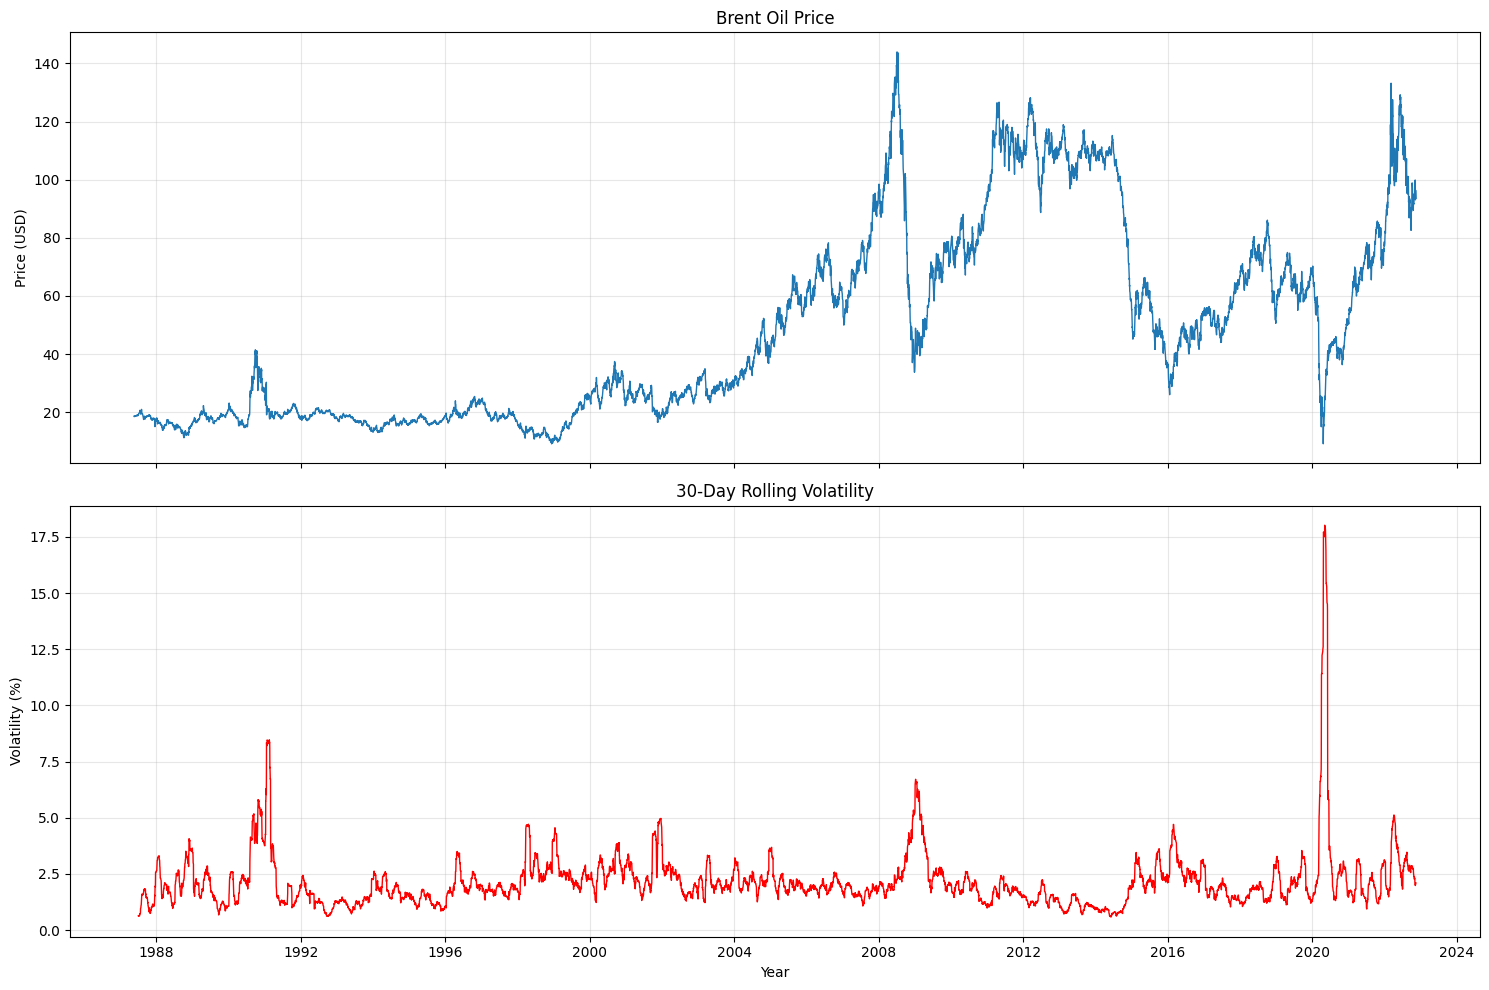

In [6]:
# Calculate rolling volatility (30-day standard deviation of daily returns)
df['volatility_30d'] = df['price_change_pct'].rolling(window=30).std()

# Plot price and volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Price plot
ax1.plot(df.index, df['Price'], linewidth=1)
ax1.set_title('Brent Oil Price')
ax1.set_ylabel('Price (USD)')
ax1.grid(True, alpha=0.3)

# Volatility plot
ax2.plot(df.index, df['volatility_30d'], color='red', linewidth=1)
ax2.set_title('30-Day Rolling Volatility')
ax2.set_ylabel('Volatility (%)')
ax2.set_xlabel('Year')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Step 10: Convert to Log Returns (Key for Modeling)

Why log returns:

They're more stationary than prices

Better for statistical modeling

Represent percentage changes

Symmetric around zero

Log returns statistics:
count    8981.000000
mean        0.000178
std         0.025571
min        -0.643699
25%        -0.011222
50%         0.000395
75%         0.012197
max         0.412023
Name: log_returns, dtype: float64


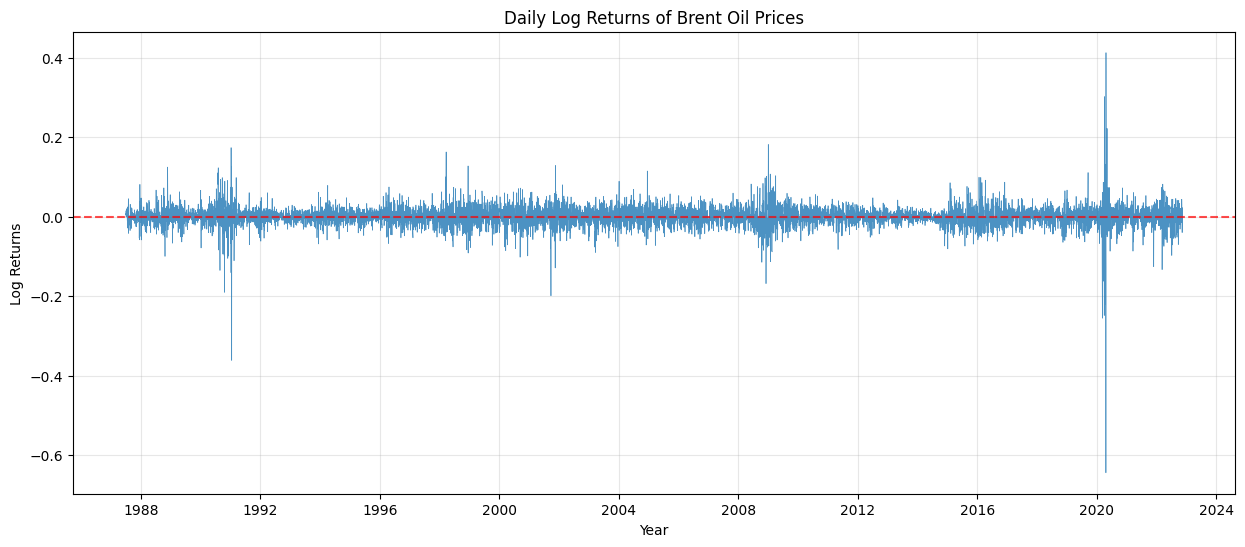

In [7]:
# Calculate log returns
df['log_price'] = np.log(df['Price'])
df['log_returns'] = df['log_price'].diff()

# Remove the first row (NaN due to diff)
df_clean = df.dropna()

print("Log returns statistics:")
print(df_clean['log_returns'].describe())

# Plot log returns
plt.figure(figsize=(15, 6))
plt.plot(df_clean.index, df_clean['log_returns'], linewidth=0.5, alpha=0.8)
plt.title('Daily Log Returns of Brent Oil Prices')
plt.xlabel('Year')
plt.ylabel('Log Returns')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.show()

Step 11: Distribution Analysis

 If returns aren't normal, we might need robust models. Oil returns typically have "fat tails" (more extreme events than normal distribution predicts).

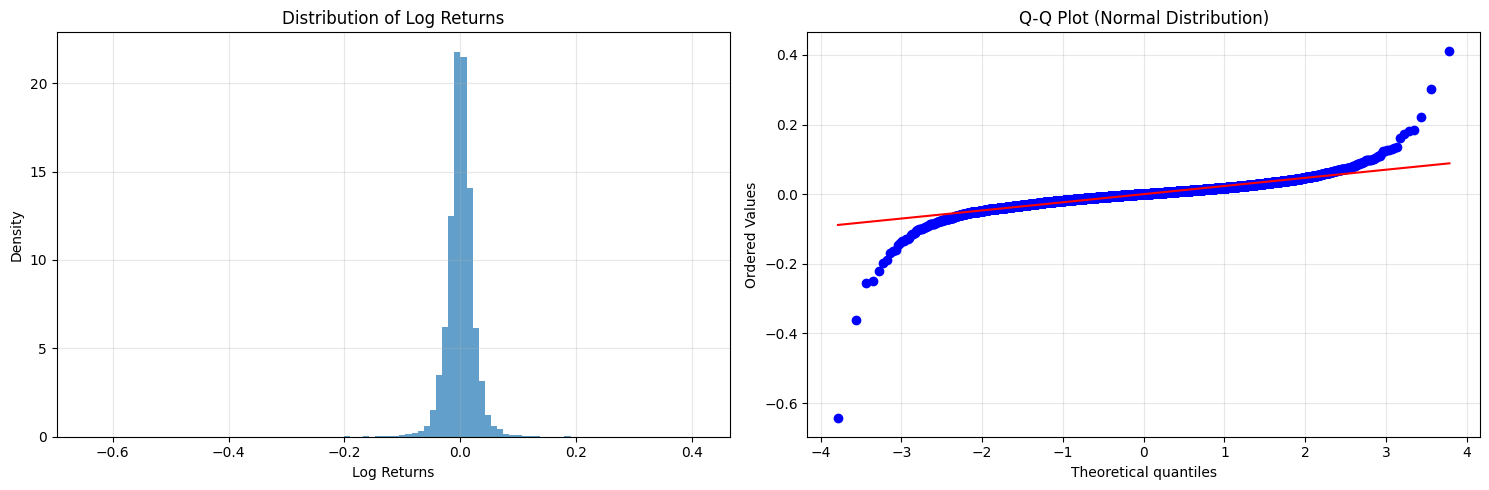

Jarque-Bera test for normality:
Statistic: 1618313.55, P-value: 0.0000
Returns are NOT normally distributed (reject normality)


In [8]:
# Plot distribution of log returns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_clean['log_returns'], bins=100, alpha=0.7, density=True)
axes[0].set_title('Distribution of Log Returns')
axes[0].set_xlabel('Log Returns')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)

# Q-Q plot to check if returns are normally distributed
from scipy.stats import probplot
probplot(df_clean['log_returns'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normal Distribution)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if returns are normally distributed
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(df_clean['log_returns'])
print(f"Jarque-Bera test for normality:")
print(f"Statistic: {jb_stat:.2f}, P-value: {jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print("Returns are NOT normally distributed (reject normality)")
else:
    print("Returns appear normally distributed")

Step 12: Autocorrelation Analysis

If returns show little autocorrelation, they're close to random walk

If squared returns show strong autocorrelation, there's volatility clustering

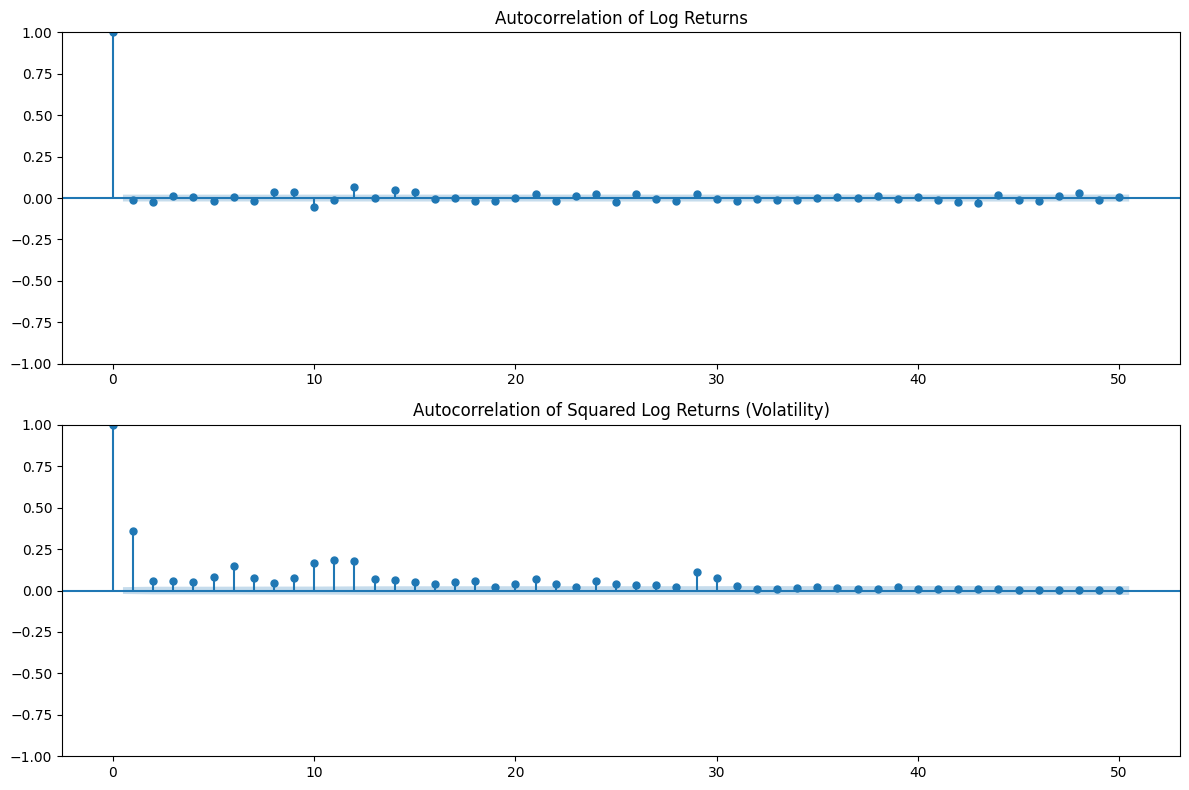

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation of returns
plot_acf(df_clean['log_returns'].dropna(), lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation of Log Returns')

# Autocorrelation of squared returns (volatility clustering)
plot_acf(df_clean['log_returns'].dropna()**2, lags=50, ax=axes[1])
axes[1].set_title('Autocorrelation of Squared Log Returns (Volatility)')

plt.tight_layout()
plt.show()

Step 13: Time-Based Patterns

C:\Users\Antifragile\AppData\Local\Temp\ipykernel_21608\4050783195.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Antifragile\Desktop\Brent_Oil_change_point_analysis\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


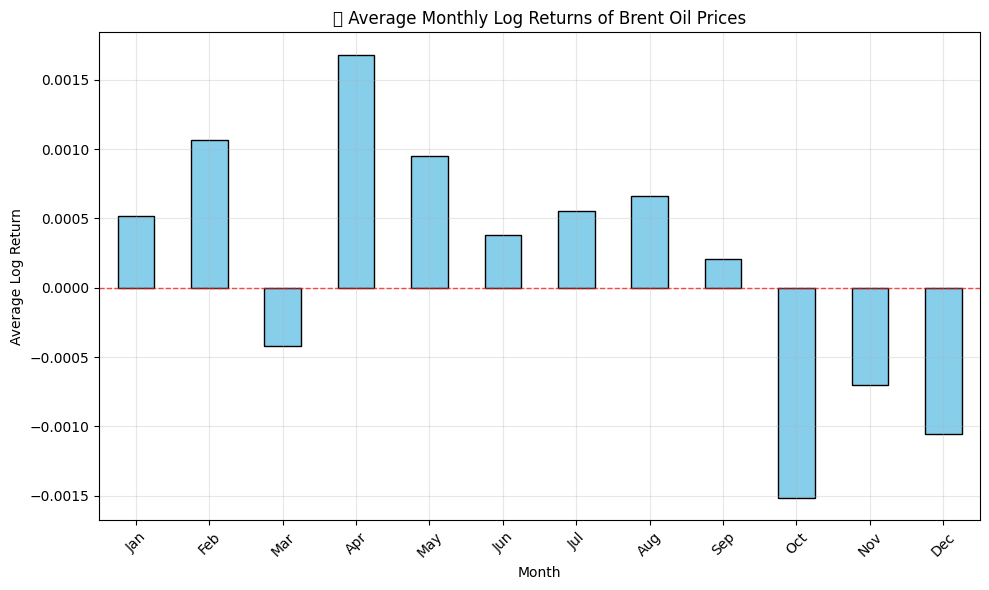

In [ ]:

df_clean = df.dropna().copy()

# Extract time components for seasonal analysis
df_clean['year'] = df_clean.index.year
df_clean['month'] = df_clean.index.month
df_clean['day_of_week'] = df_clean.index.dayofweek

# Compute average log returns by calendar month (1–12)
monthly_returns = df_clean.groupby('month')['log_returns'].mean()

# Plot average monthly returns
plt.figure(figsize=(10, 6))
monthly_returns.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('📊 Average Monthly Log Returns of Brent Oil Prices')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(
    ticks=range(12),
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    rotation=45
)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
 

Step 14: Prepare Data for Change Point Analysis

In [15]:
# Create final dataset for modeling
model_data = df_clean[['Price', 'log_returns', 'volatility_30d']].copy()

# Remove any remaining NaN values
model_data = model_data.dropna()

print("Final dataset for modeling:")
print(f"Shape: {model_data.shape}")
print(f"Date range: {model_data.index.min()} to {model_data.index.max()}")
print("\nFirst few rows:")
print(model_data.head())

# Save processed data
model_data.to_csv('processed_brent_data.csv')
print("\nProcessed data saved to 'processed_brent_data.csv'")

Final dataset for modeling:
Shape: (8647, 3)
Date range: 1988-10-20 00:00:00 to 2022-11-14 00:00:00

First few rows:
            Price  log_returns  volatility_30d
Date                                          
1988-10-20  13.50     0.011173        3.134980
1988-10-21  13.48    -0.001483        3.134071
1988-10-24  12.20    -0.099771        3.513275
1988-10-25  12.08    -0.009885        3.353715
1988-10-26  12.08     0.000000        3.267512

Processed data saved to 'processed_brent_data.csv'
